# Flower's type classification using TensorFlow

The dataset used for this classification task contains 3670 images which belongs to 5 Classes namely:

>1. Rose
2. Daisy
3. Dandelion
4. Sunflowers
5. Tulips

Image classification is done using two models:

>1. Custom CNN model created and trained from scratch. This model had 4 Convolutional layers along with Pooling, Fully Connected and Softmax layers.

>2. Transfer learning - A method in which a pre-trained [MobileNet](https://arxiv.org/pdf/1704.04861.pdf) model by Google was used for classification. The MobileNet model had 27 Convolutional layers along with Pooling, Fully Connected and Softmax layers.

## Results:

The Custom CNN model achieved 79.32% validation accuracy after training for 63 Epochs. Whereas, MobileNet achieved 11.02% more validation accuracy than the custom CNN model i.e. 90.34% in just 30 Epochs. 

## Import required libraries

In [5]:
import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Loading the Flowers dataset

In [2]:
def loading_data():
  """
  Downloads the flowers dataset and extracts its contents.

  The dataset downloaded contains images of 5 types of flowers:

  1. Rose
  2. Daisy
  3. Dandelion
  4. Sunflowers
  5. Tulips
  """

  _URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

  zip_file = tf.keras.utils.get_file(origin=_URL,
                                      fname="flower_photos.tgz",
                                      extract=True)

  base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')
  
  classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

  return base_dir, classes

## Splitting the dataset into Training and Validation set

In [3]:
def creation_of_train_val_set_from_dataset(base_dir, classes):
  """
  Creates training and validation folders with 80% of the images from each class as training dataset and
  remaining 20% of the dataset is used as validation set

  Input parameters: 1. base_dir - Path to base directory of the images
                    2. classes - Number of classes of the images
  """

  for cl in classes:
    img_path = os.path.join(base_dir, cl)
    images = glob.glob(img_path + '/*.jpg')
    print("{}: {} Images".format(cl, len(images)))
    num_train = int(round(len(images)*0.8))
    train, val = images[:num_train], images[num_train:]

    for t in train:
      if not os.path.exists(os.path.join(base_dir, 'train', cl)):
        os.makedirs(os.path.join(base_dir, 'train', cl))
      shutil.move(t, os.path.join(base_dir, 'train', cl))

    for v in val:
      if not os.path.exists(os.path.join(base_dir, 'val', cl)):
        os.makedirs(os.path.join(base_dir, 'val', cl))
      shutil.move(v, os.path.join(base_dir, 'val', cl))
      
  # For convenience, setting the path for the training and validation sets

  train_dir = os.path.join(base_dir, 'train')
  val_dir = os.path.join(base_dir, 'val')

  return train_dir, val_dir

## Data augmentation techniques on the training and validation data

In [4]:
def data_augmentation_train_data(BATCH_SIZE, IMG_SHAPE, train_dir):

  """
  Data Augmentation for the Validation Set.

  Input parameter: 1. BATCH_SIZE - Number of images per iteration
                   2. IMG_SHAPE - To resize the image to a particular size
                   3. train_dir - The path for validation dataset
  """

  image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=50,
                    width_shift_range=.2,
                    height_shift_range=.2,
                    horizontal_flip=True,
                    vertical_flip=True,
                    zoom_range=0.5
                    )


  train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=BATCH_SIZE,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )
                                                
  return train_data_gen

In [6]:
def data_augmentation_val_data(BATCH_SIZE, IMG_SHAPE, val_dir):
  """
  Data Augmentation for the Validation Set.

  Input parameter: 1. BATCH_SIZE - Number of images per iteration
                   2. IMG_SHAPE - To resize the image to a particular size
                   3. val_dir - The path for validation dataset
  """

  image_gen_val = ImageDataGenerator(rescale=1./255)

  val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                    directory=val_dir,
                                                    target_size=(IMG_SHAPE, IMG_SHAPE),
                                                    class_mode='sparse')
  
  return val_data_gen

## Visualization of the images

In [5]:
def plotImages(images_arr):
  """
  This function plots images in the form of a grid with 1 row and 5 columns 
  where images are placed in each column.

  Input parameter: 1. images_arr - List of Images to be displayed
  """
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip( images_arr, axes):
      ax.imshow(img)
  plt.tight_layout()
  plt.show()

## Custom CNN model

In [7]:
def CNN_model(BATCH_SIZE, IMG_SHAPE, EPOCHS, PATIENCE, num_classes, train_data_gen, val_data_gen):    
  """
  Creates a custom CNN model using the Convolutional, MaxPooling, Fully connected and the Dropout laers.

  Input parameters: 1. BATCH_SIZE - Number of images per iteration
                    2. IMG_SHAPE - To resize the image to a particular size
                    3. num_classes - Number of output classes
                    4. EPOCHS - Number of epochs until which the training process continues
                    5. PATIENCE - The training stops when the accuracy don't improve
                    6. train_data_gen - Training dataset
                    7. val_data_gen - Validation dataset

  Output parameter: 1. history - It returnes the history of values which contains 'training accuracy',
                                 'training loss', 'validation accuracy', 'validation loss' for the
                                 number of EPOCHS until which the training was carried out. 
  """

  model = Sequential()

  model.add(Conv2D(32, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, 3, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, 3, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(256, 3, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(256, activation='relu'))

  model.add(Dropout(0.5))
  model.add(Dense(num_classes))
  
  model.summary()

  # Model compilation
  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  # Training the model
  early_stopping = keras.callbacks.EarlyStopping(patience=PATIENCE)
  history = model.fit(
      train_data_gen,
      steps_per_epoch=int(np.ceil(train_data_gen.n / float(BATCH_SIZE))),
      epochs=EPOCHS,
      validation_data=val_data_gen,
      validation_steps=int(np.ceil(val_data_gen.n / float(BATCH_SIZE))),
      callbacks = [early_stopping]
  )
  
  return history

## Transfer learning

In [8]:
def Transfer_learning(IMG_SHAPE, num_classes, EPOCHS, PATIENCE, train_data_gen, val_data_gen):

  """
  This function downloads the pre-trained MobileNet model and 
  replaces the final layer according to the number of output classes.

  Following which the optimizer is defined and which is then used to train the model.
  

  Input parameters: 1. IMG_SHAPE - The size which is accepted by the MobileNet model
                    2. num_classes - Number of output classes
                    3. EPOCHS - Number of epochs until which the training process continues
                    4. PATIENCE - The training stops when the accuracy don't improve
                    5. train_data_gen - Training dataset
                    6. val_data_gen - Validation dataset

  Output parameter: 1. history - It returnes the history of values which contains 'training accuracy',
                                 'training loss', 'validation accuracy', 'validation loss' for the
                                 number of EPOCHS until which the training was carried out.
  """

  URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
  feature_extractor = hub.KerasLayer(URL,
                                    input_shape=(IMG_SHAPE, IMG_SHAPE, 3))

  # To avoid changing the weights of the pre-trained MobileNet model
  feature_extractor.trainable = False

  model = tf.keras.Sequential([
                feature_extractor,
                tf.keras.layers.Dense(num_classes)
                ])
  
  model.summary()

  # Model Compilation
  model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

  # Training the model
  early_stopping = keras.callbacks.EarlyStopping(patience=PATIENCE)
  history = model.fit(train_data_gen,
                      epochs=EPOCHS,
                      validation_data=val_data_gen,
                      callbacks = [early_stopping])

  return history

## Visualization of training and validation loss

In [9]:
def visualization_train_val_acc_loss(history, EPOCHS):
  """
  This function plots Epochs vs. history of training and validation accuracy and loss

  Input parameters: 1. History of values of both training and validation accuracy and loss
                    2. Epochs
  """
  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(EPOCHS)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

## Flower's type classification using custom CNN model and pre-trained MobileNet model

228818944/228813984 [==============================] - 7s 0us/step
roses: 641 Images
daisy: 633 Images
dandelion: 898 Images
sunflowers: 699 Images
tulips: 799 Images
Found 2935 images belonging to 5 classes.
Found 735 images belonging to 5 classes.



\Training and validating the dataset using the "custom CNN model" built from scratch 


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_____________________________________________

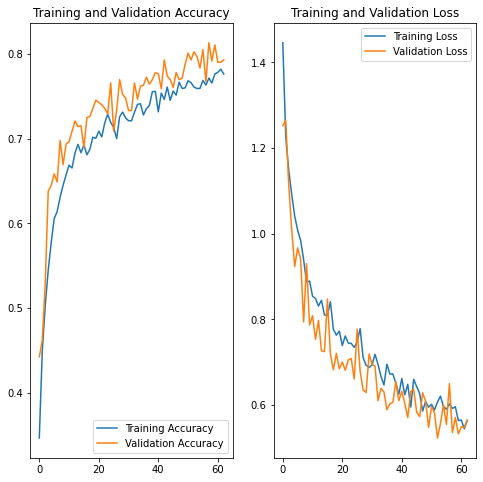




Training and validating the dataset using the "pre-trained MobileNet" model 


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/100
74/74 [==============================] - 42s 528ms/step - loss: 1.1718 - accuracy: 0.5283 - val_loss: 0.5421 - val_accuracy: 0.8082
Epoch 2/100
74/74 [==============================] - 39s 523ms/step - loss: 0.5639 - accuracy: 0.7989 - val_loss: 0.4500 - val_accuracy: 0.8381
Epoch 3/100
74/74 [==============================] - 38s 520ms/step - loss: 0.4904 - accuracy: 0.8218 - val_loss: 0.3986 - val_accur

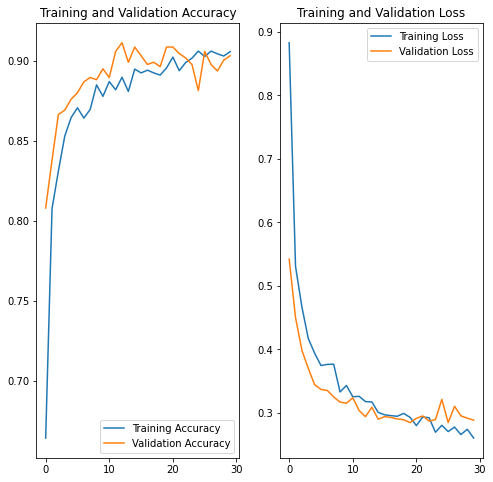

In [10]:
if __name__ == '__main__':

  #### Load the data from an URL and add it to a directory ####
  base_dir, classes = loading_data()
  num_classes = len(classes)

  #### Create a training and validation directories with images from all classes ####
  train_dir, val_dir = creation_of_train_val_set_from_dataset(base_dir, classes)

  BATCH_SIZE = 40
  IMG_SHAPE = 224 # Pre-trained MobileNet by Google accepts this image size
  PATIENCE = 10 # This stops training, when the validation accuracy do not improve much for particular number of EPOCHS
  EPOCHS = 100

  #### Different Data Augmentation methods to avoid Overfitting ####
  # Data Augmentation on training set
  train_data_gen = data_augmentation_train_data(BATCH_SIZE, IMG_SHAPE, train_dir)

  #### Data Augmentation on training set  ####
  val_data_gen = data_augmentation_val_data(BATCH_SIZE, IMG_SHAPE, val_dir)

  #### Use this function to create/train/validate a CNN model created especially for this application ####
  print('\n\n\nTraining and validating the dataset using the "custom CNN model" built from scratch \n\n')
  history = CNN_model(BATCH_SIZE, IMG_SHAPE, EPOCHS, PATIENCE, num_classes, train_data_gen, val_data_gen)
  # Visualization of accuracy and loss against a range of EPOCHS ####
  EPOCHS_at_the_end_of_training = len(history.history['accuracy'])
  visualization_train_val_acc_loss(history, EPOCHS_at_the_end_of_training)

  #### Use this function to create a CNN model using the pre-trained 'MobileNet' by Google/train/validate (Transfer Learning) ####
  print('\n\n\nTraining and validating the dataset using the "pre-trained MobileNet" model \n\n')
  history = Transfer_learning(IMG_SHAPE, num_classes, EPOCHS, PATIENCE, train_data_gen, val_data_gen)
  # Visualization of accuracy and loss against a range of EPOCHS ####
  EPOCHS_at_the_end_of_training = len(history.history['accuracy'])
  visualization_train_val_acc_loss(history, EPOCHS_at_the_end_of_training)